CNN Project - AIML Course
Executed on google collab

In [ ]:
import tensorflow as tf
%tensorflow_version 2.x

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Drive Setup

Mounting the google drive and accessing the shared content through a link established to training data repostory

In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
ls "/content/drive/MyDrive/AIML/Projects/CNN/data/seedlingData/train" # List the directory containing training data

 Black-grass/        'Common wheat'/      'Scentless Mayweed'/
 Charlock/           'Fat Hen'/           'Shepherds Purse'/
 Cleavers/           'Loose Silky-bent'/  'Small-flowered Cranesbill'/
'Common Chickweed'/   Maize/              'Sugar beet'/


In [ ]:
ls '/content/drive/MyDrive/AIML/Projects/CNN/data/seedlingData/Seedling - Prediction'

Predict.png


# Libraries and Helper Functions

In [ ]:
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras import optimizers

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score ,average_precision_score ,accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from numpy import savez_compressed
from numpy import load

import warnings
warnings.filterwarnings('ignore')

### FNN Functions

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
def ffn_model(actfn='relu',kernel_initializer=None,batchnorm=0,dropout=0.3,drop=0,hiddennodes=2,nodes=[128,64],input_shp=(128,128,3), target=12):
    model = Sequential()
    model.add(Flatten(input_shape=input_shp))
    for i in range(0,hiddennodes):
        model.add(Dense(nodes[i],kernel_initializer=kernel_initializer))
        if batchnorm:
            model.add(BatchNormalization())
        if drop:
            model.add(Dropout(dropout))
        model.add(Activation(actfn))
    model.add(Dense(target))
    model.add(Activation('softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.01)
    lr=opt.learning_rate
    # Calling this to ensure that values are set. refer https://github.com/tensorflow/tensorflow/issues/31287

    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    print(model.summary())
    return model

In the run command below

Commented the modelcheckpoint off as the writing to google drive takes time and disconnects the GPU session.

This happened many times on google collab.  Please ensure that you consider the infra requirements for the projects being asked to be executed.

In [ ]:
def run_fnn(title,clf,data_gen,X_train,y_train,
            X_val,y_val,
            X_test,y_test,checkpoint_path="NONE",
            n_epochs=500,n_batch=350):
    print('new function')

    pat=max(int(n_epochs*0.2),1) # patience for early stopping set at 20% of the epochs.

    #eary stopping in case the there is no improvement in last 0.2 * Epoch iterations
    early_stop = EarlyStopping(monitor='val_acc', mode='max', patience=pat, min_delta=0.01, verbose=1)

    #Change the learning rate in case there is no change to accuracy in last 5 iterations
    #LR_reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)

    _callback=[early_stop]

    #Save the best model during iterations.. commenting this off
    if(checkpoint_path !="NONE"):
      checkpoint = ModelCheckpoint(checkpoint_path, verbose=1, save_best_only=True)
      _callback=[early_stop,LR_reducer,checkpoint]

    #shuffle set as False so that all data points get covered at least once in the batch.
    clf_history=clf.fit(datagen.flow(X_train, y_train, batch_size=n_batch,shuffle=False),
                epochs =n_epochs,
                verbose = 1,
                workers=4,
                #batch_size=n_batch,
                validation_data=data_gen.flow(X_val, y_val, batch_size=n_batch,shuffle=False),
                steps_per_epoch=int(len(X_train) // n_batch),
                shuffle=True,
                callbacks=_callback) #checkpoint,annealer

    results = clf.evaluate(data_gen.flow(X_test, y_test, batch_size=n_batch,shuffle=False),
                           workers=6)

    print('============================================')
    print('Model results on the hold out set: Loss{0}, Acc:{1}'.format(results[0],results[1]))
    print('============================================')

    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    plt.title(title)
    ax.plot(clf_history.history['loss'], 'r', label='train')
    ax.plot(clf_history.history['val_loss'], 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=8)
    ax.set_ylabel(r'Loss', fontsize=8)
    ax.legend()
    ax.tick_params(labelsize=20)

    # Plot the accuracy
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.plot(clf_history.history['acc'], 'r', label='train')
    ax.plot(clf_history.history['val_acc'], 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=8)
    ax.set_ylabel(r'Accuracy', fontsize=8)
    ax.legend()
    ax.tick_params(labelsize=20)

## Helper Functions

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_grid(image_list, nrows, ncols, label_list=None, show_labels=False, figsize=(10,10)):
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(nrows, ncols),
                     axes_pad=0.5,
                     share_all=True,
                     )
    #print(class_dict)
    for i in range(nrows*ncols):
        #print(i)
        ax = grid[i]
        ax.set_title(label_list[i], fontdict={'fontsize':12}, loc='center', color = "k")
        ax.imshow(image_list[i],cmap='Greys_r')
        ax.axis('off')

In [ ]:
def multi_algo_execution(X_train, X_test, y_train, y_test,
                    model, name,param_grid, cv=10, scoring_fit='accuracy',randomSearch=False):

        if (randomSearch == False):
            modelSearch = GridSearchCV(
            estimator=model,
            param_grid=param_grid,
            cv=cv,
            n_jobs=-1,
            scoring=scoring_fit,
            verbose=2
            )
        else:
            modelSearch = RandomizedSearchCV(
                estimator = model,
                param_distributions = param_grid,
                n_iter = 100,
                cv = 3,
                verbose=2,
                random_state=1333,
                n_jobs = -1,
                scoring=scoring_fit
            )

        fitted_model = modelSearch.fit(X_train, y_train)
        best_model = fitted_model.best_estimator_

        pred = best_model.predict(X_test)


        accuracy=accuracy_score(y_test, pred)
        precision=precision_score(y_test, pred, average='weighted')
        recall=recall_score(y_test, pred,average='weighted')
        f1=f1_score(y_test, pred,average='weighted')
        #roc_auc=roc_auc_score(y_test,pred,average='weighted',multi_class='ovr')
        #pr_auc=average_precision_score(y_test,pred,average='weighted',multi_class='ovr')

        return [name,best_model,pred,accuracy,precision,recall,f1]

# PART ONE

## [Skip] Read and save Images (skip on runtime change)

In [ ]:
path = '/content/drive/MyDrive/AIML/Projects/CNN/data/seedlingData/train/*/*.png'

In [ ]:
files = glob(path)

In [ ]:
imageData = []
imageLabels = []

# Obtain images and resizing, obtain labels
for img in tqdm(files):
    #print(str(j) + "/" + str(num), end="\r")
    imageData.append(
        cv2.resize(cv2.imread(img), (imgsize, imgsize))
    )
    imageLabels.append(img.split('/')[-2])  # Get image label (folder name)

imageData = np.asarray(imageData)
imageLabels = pd.DataFrame(imageLabels)

100%|██████████| 4767/4767 [1:04:33<00:00,  1.23it/s]


In [ ]:
savez_compressed('/content/drive/MyDrive/AIML/Projects/CNN/output/rawImageData.npz', imageData)

In [ ]:
savez_compressed('/content/drive/MyDrive/AIML/Projects/CNN/output/rawImageLabels.npz', imageLabels)

## [Skip] Display images

In [ ]:
image_data_fromfile= load('/content/drive/MyDrive/AIML/Projects/CNN/output/rawImageData.npz')

imageData=image_data_fromfile['arr_0']

np_load_old = np.load

# modify the default parameters of np.load

np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

image_label_fromfile= np.load('/content/drive/MyDrive/AIML/Projects/CNN/output/rawImageLabels.npz')

imageLabels=image_label_fromfile['arr_0']

np.load = np_load_old

In [ ]:
unique, counts = np.unique(imageLabels, return_counts=True)

summary=(np.asarray((unique, counts)).T)

In [ ]:
summary

array([['Black-grass', 263],
       ['Charlock', 390],
       ['Cleavers', 287],
       ['Common Chickweed', 611],
       ['Common wheat', 221],
       ['Fat Hen', 475],
       ['Loose Silky-bent', 671],
       ['Maize', 221],
       ['Scentless Mayweed', 516],
       ['Shepherds Purse', 231],
       ['Small-flowered Cranesbill', 496],
       ['Sugar beet', 385]], dtype=object)

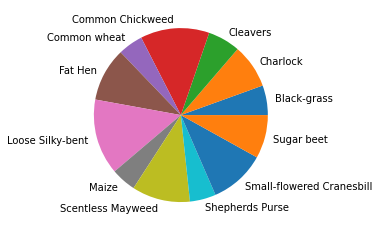

In [ ]:
plt.pie(counts, labels = unique)
plt.show()

In [ ]:
a=np.unique(imageLabels, return_index=True)
dispdata=[]
dislabels=[]
for i in a[1]:
    dislabels.append(imageLabels[i])
    dispdata.append(imageData[i])

In [ ]:
a

(array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
        'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
        'Scentless Mayweed', 'Shepherds Purse',
        'Small-flowered Cranesbill', 'Sugar beet'], dtype=object),
 array([   0,  263,  653,  940, 1551, 1772, 2247, 2918, 3139, 3655, 3886,
        4382]))

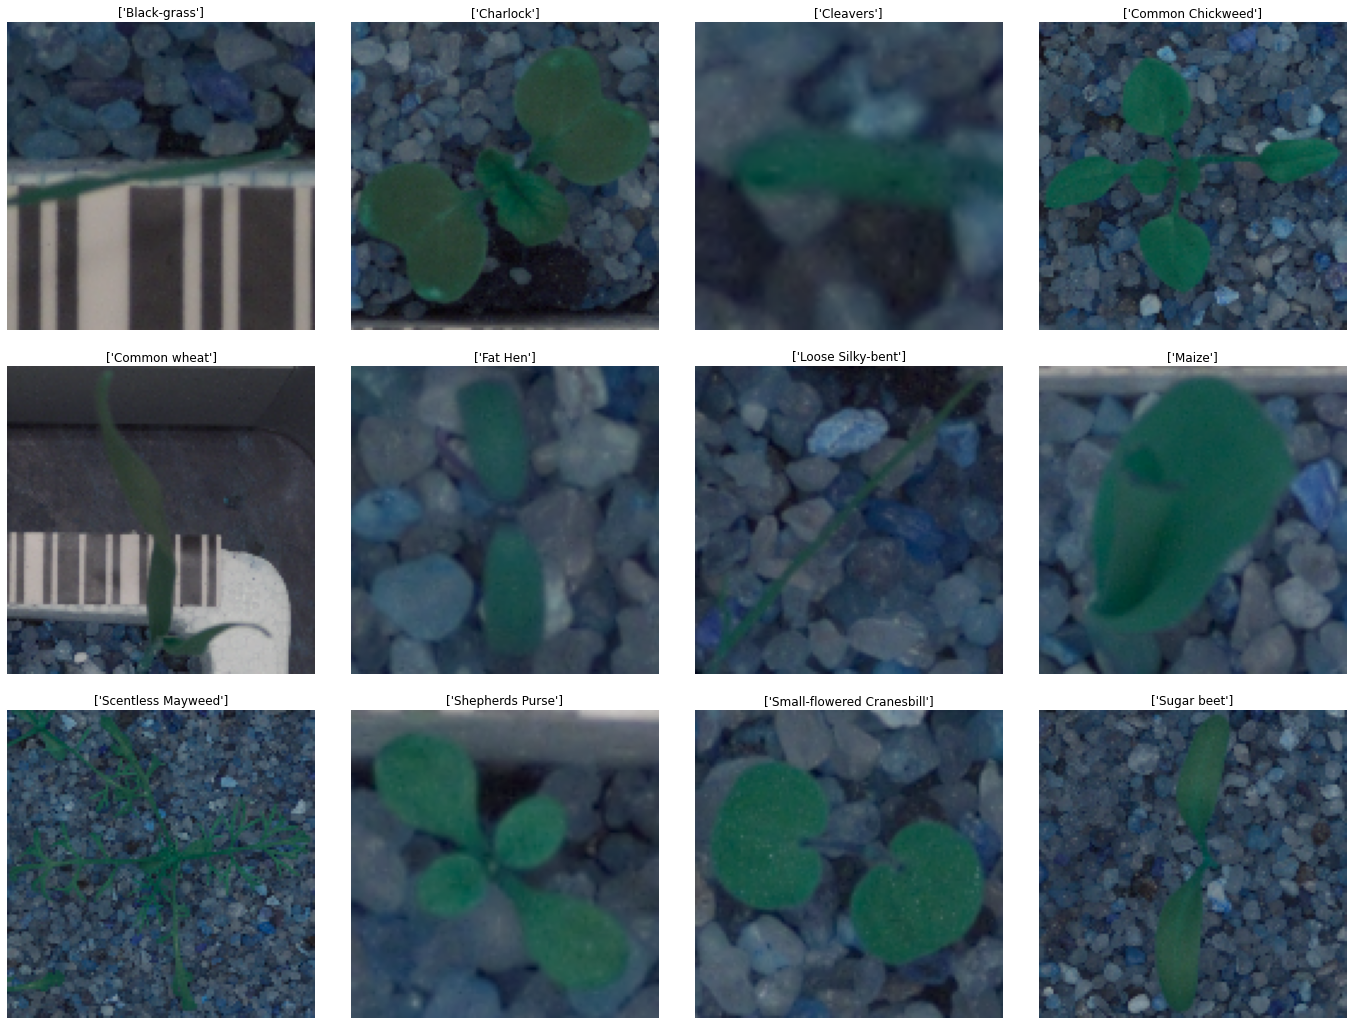

In [ ]:
show_grid(dispdata, 3, 4, label_list=dislabels, show_labels=True, figsize=(24,24))

## [Skip] Cleaning up of images

Skip this section on runtime changes on collab

As the images have varied background, some cleanup can be done using OpenCV. The following were attempted based on a Kaggle reference..
1. Blurring the image to remove noise
2. Converting image to HSV , as that is generally preferred for object recognition.
3. Using the closing operation which is generally used to close any small holes inside the forgeround object.
4. Then converting the entire operations into a boolean mask.
5. Finally plotting the original and cleaned image.

As the seedlings all have green colour we can go ahead and remove the background colour based on the colour.

This cleaning up is done to remove unnecessary noise that is present in the images.

The idea for this was referenced from various kaggle competitions answers published on the plant-seedling topic.



100%|██████████| 4767/4767 [00:04<00:00, 1190.56it/s]


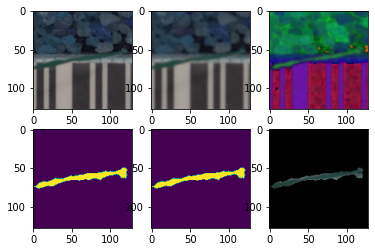

In [ ]:
clearTrainImg = []
examples = []; getEx = True
for img in tqdm(imageData):
    # Use gaussian blur
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)

    # Convert to HSV image
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)

    # Create mask (parameters - green color range)
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Create bool mask
    bMask = mask > 0

    # Apply the mask
    clear = np.zeros_like(img, np.uint8)  # Create empty image
    clear[bMask] = img[bMask]  # Apply boolean mask to the origin image

    clearTrainImg.append(clear)  # Append adds and object to the end of a list (image without backgroung)

    # Show examples
    if getEx:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blurred image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background
        getEx = False

clearTrainImg = np.asarray(clearTrainImg)

Sample of one image from each class and the cleaned up image

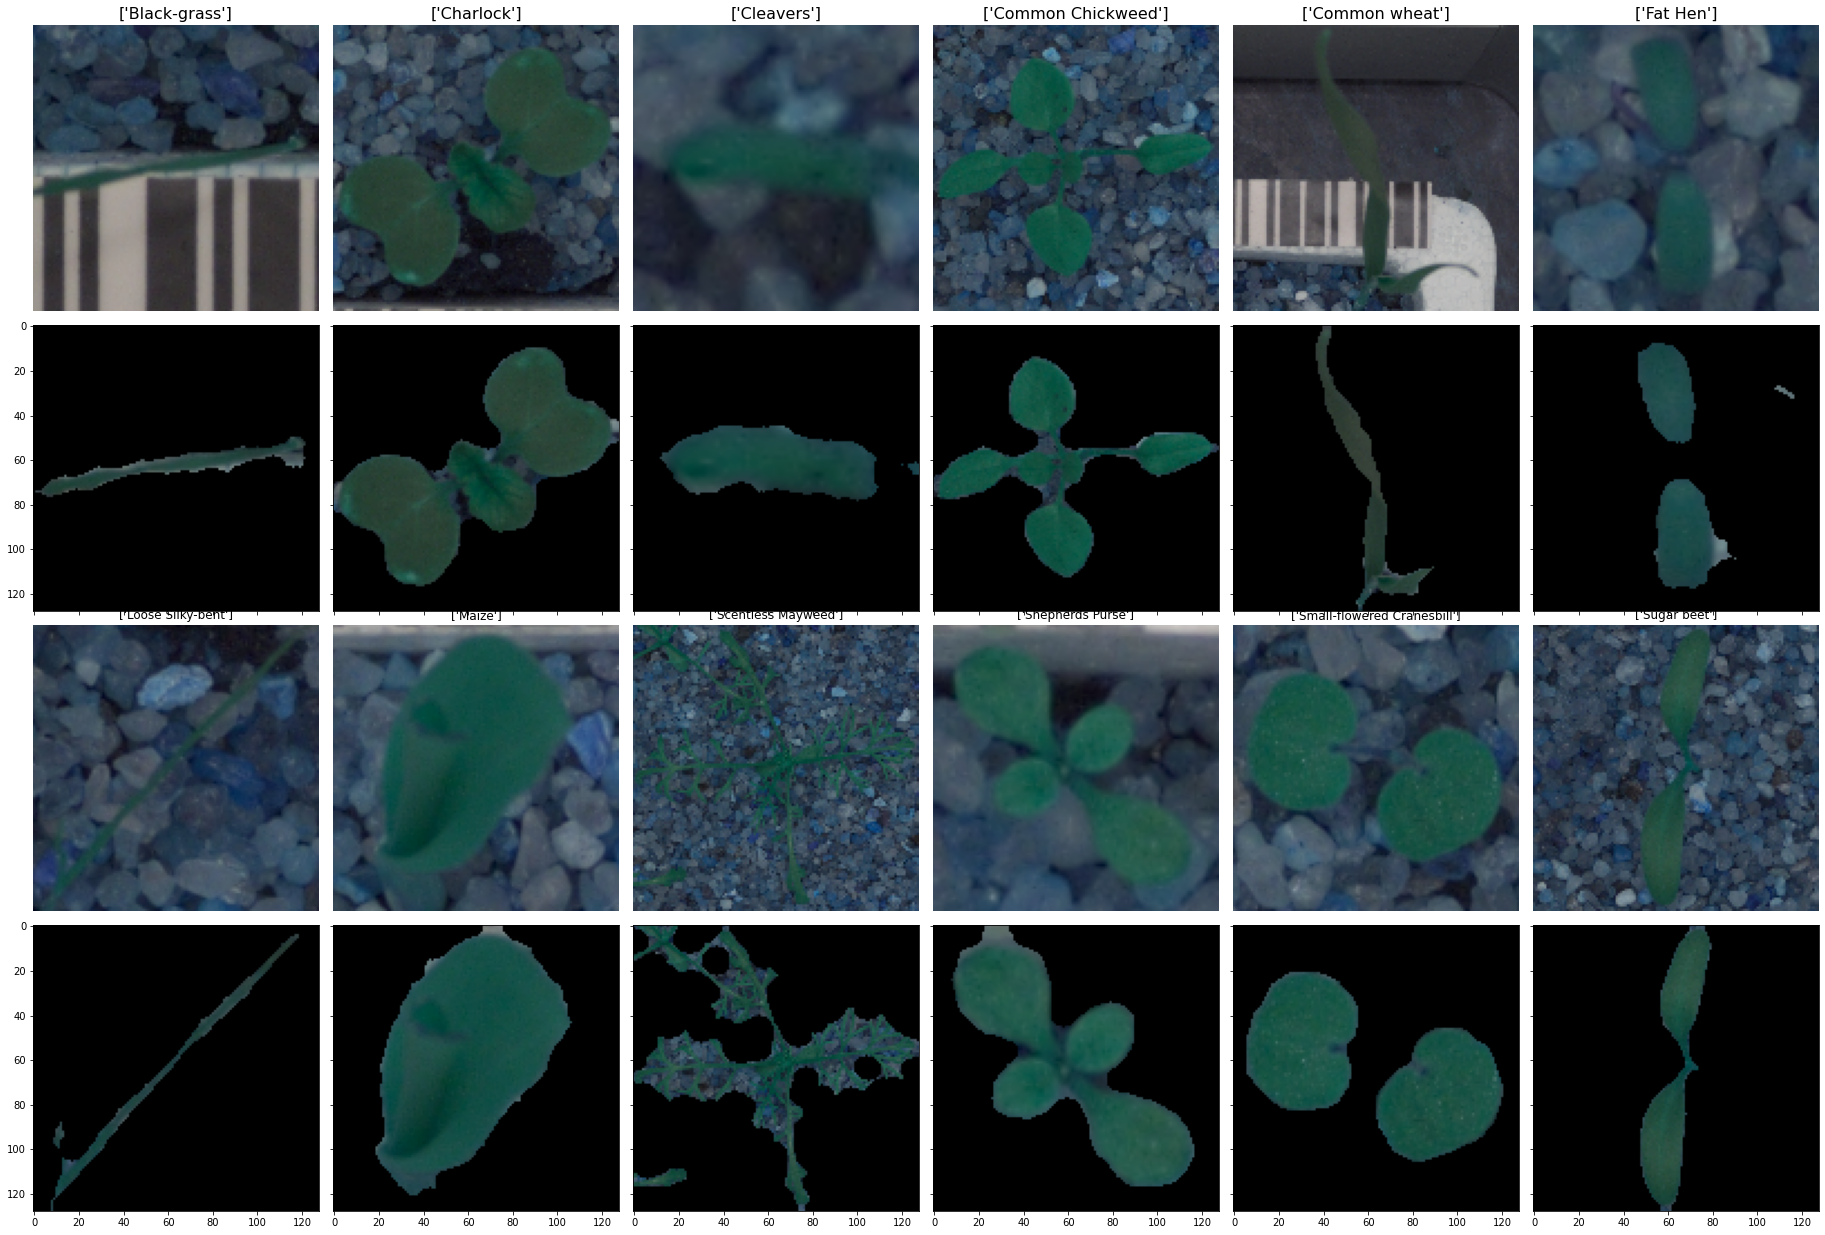

In [ ]:
fig = plt.figure(None, (32,32),frameon=False)
grid = ImageGrid(fig, 111,
                nrows_ncols=(4, 6),
                axes_pad=0.2,
                share_all=True,
                     )
    #print(class_dict)
for i in range(12):
    #print(i)
    if( i <6):
        #print(a[1][i])
        ax = grid[i]
        ax.set_title(dislabels[i], fontdict={'fontsize':16}, loc='center', color = "k")
        ax.imshow(dispdata[i],cmap='Greys_r')
        ax.axis('off')
        ax = grid[i+6]
        ax.imshow(clearTrainImg[a[1][i]],cmap='Greys_r')
    if( i >=6):
        #print(a[1][i])
        ax = grid[i+6]
        ax.set_title(dislabels[i], fontdict={'fontsize':12}, loc='center', color = "k")
        ax.imshow(dispdata[i],cmap='Greys_r')
        ax.axis('off')
        ax = grid[i+12]
        ax.imshow(clearTrainImg[a[1][i]],cmap='Greys_r')

Save the numpy array into disk so that we can start the process from here

In [ ]:
#Save the cleaned up data into a file to load it again


In [ ]:

savez_compressed('/content/drive/MyDrive/AIML/Projects/CNN/output/cleanedImagesdata.npz', clearTrainImg)


In [ ]:
savez_compressed('/content/drive/MyDrive/AIML/Projects/CNN/output/cleanedImagesLabels.npz', imageLabels)

## Load Cleaned Images from File

In [ ]:
image_array= load('/content/drive/MyDrive/AIML/Projects/CNN/output/cleanedImagesdata.npz')


In [ ]:
imgdata=image_array['arr_0']

In [ ]:
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [ ]:
image_labels= np.load('/content/drive/MyDrive/AIML/Projects/CNN/output/cleanedImagesLabels.npz')

In [ ]:
imglbl=image_labels['arr_0']

In [ ]:
np.load = np_load_old

In [ ]:
image_array=imgdata
image_labels=imglbl

In [ ]:
(image_array.shape, image_labels.shape)

((4767, 128, 128, 3), (4767, 1))

## Supervised Learning using SVC

In [ ]:
SEED=1333
imgsize=128

In [ ]:
(image_array.shape, image_labels.shape)

((4767, 128, 128, 3), (4767, 1))

Prepare data for SVM ... Label encode the target.. Flatten the image data

In [ ]:
le = LabelEncoder()
le.fit(image_labels.ravel())
y=le.transform(image_labels.ravel())

In [ ]:
colsize = len(image_array[0])*len(image_array[0][0])*len(image_array[0][0][0])
X=image_array.reshape(len(image_array),colsize)

(X.shape,y.shape)

((4767, 49152), (4767,))

In [ ]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

(X_train_svm.shape, y_train_svm.shape),(X_test_svm.shape,y_test_svm.shape)

(((3813, 49152), (3813,)), ((954, 49152), (954,)))

Perform PCA as the number of features is more than number of samples. PCA would take min of number of features to number of samples.

 We will thereby select total number of features = total number of samples

In [ ]:
pca = PCA(n_components=min(X_train_svm.shape[1],X_train_svm.shape[0]))
pca.fit(X_train_svm)

PCA(copy=True, iterated_power='auto', n_components=3813, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

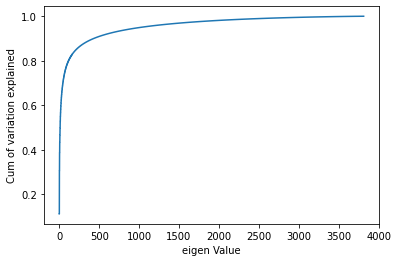

In [ ]:
plt.step(list(range(1,X_train_svm.shape[0]+1)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [ ]:
X_train_pca=pca.transform(X_train_svm)
X_test_pca=pca.transform(X_test_svm)

Method to perform Randomsearch on SVC restricted to maximum 100 iterations

In [ ]:
param_grid = { # SVC
        'kernel': ['rbf', 'poly', 'linear'],
        'C': [0.1, 1, 10,100],
        'class_weight':['balanced',None]
    }
name,best_model,pred,accuracy,precision,recall,f1 = multi_algo_execution(X_train_pca,
               X_test_pca,
               y_train_svm,
               y_test_svm,
               SVC(),
               'SVC',
               param_grid,randomSearch=True)

print('bestModel {0}'.format(best_model))
print('accuracy {0}'.format(accuracy))
print('precision {0}'.format(precision))
print('recall {0}'.format(recall))
print('f1 {0}'.format(f1))

### Results from fitting SVC

bestModel SVC(C=100, break_ties=False, cache_size=200,
class_weight='balanced', coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf', max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)

accuracy 0.7054507337526206

precision 0.6976179697604464

recall 0.7054507337526206

f1 0.6960064325019626

## Neural Network

1. Label encode target variable.
2. Split train and test data.
3. One hot enchode the target variable

In [ ]:
SEED=1333

In [ ]:
a=image_labels.ravel()
a.shape

(4767,)

In [ ]:
le = LabelEncoder()
le.fit(a)
y=le.transform(a)

(image_array.shape,y.shape)

((4767, 128, 128, 3), (4767,))

In [ ]:
X_train_fnn, X_test_fnn, y_train_fnn, y_test_fnn = train_test_split(image_array, y, test_size=0.2, random_state=SEED, stratify=y)

(X_train_fnn.shape, y_train_fnn.shape),(X_test_fnn.shape,y_test_fnn.shape)

(((3813, 128, 128, 3), (3813,)), ((954, 128, 128, 3), (954,)))

In [ ]:
y_train_cat=to_categorical(y_train_fnn)
y_test_cat=to_categorical(y_test_fnn)

(X_train_fnn.shape,X_test_fnn.shape),(y_train_cat.shape,y_test_cat.shape)

(((3813, 128, 128, 3), (954, 128, 128, 3)), ((3813, 12), (954, 12)))

### FNN Execution

In [ ]:
imgsize=128  # px to scale
SEED = 1333  # fixing random
checkpoint_path = '/content/drive/MyDrive/AIML/Projects/CNN/output/fnn_model'

In [ ]:
BATCH_SIZE=32

In [ ]:
datagen =ImageDataGenerator (rescale=1./255,
            featurewise_center=True,
            featurewise_std_normalization=True,
        )
datagen.fit(X_train_fnn)

In [ ]:
fnn_model=ffn_model(actfn='relu',kernel_initializer='he_normal',
                    batchnorm=1,dropout=0.55,drop=1,hiddennodes=3,nodes=[4000,400,64])

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 49152)             0         
_________________________________________________________________
dense (Dense)                (None, 4000)              196612000 
_________________________________________________________________
batch_normalization (BatchNo (None, 4000)              16000     
_________________________________________________________________
dropout (Dropout)            (None, 4000)              0         
_________________________________________________________________
activation (Activation)      (None, 4000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 400)               1600400   
__________________________________________________

In [ ]:
run_fnn('FullyConnected',fnn_model,datagen,
            X_train_fnn,y_train_cat,
            X_test_fnn,y_test_cat,
            X_test_fnn,y_test_cat,
            n_epochs=45,n_batch=BATCH_SIZE)

new function
Epoch 1/45


ValueError: ignored

**Summary**

Best Validation accuracy was 74 %

Best training accuracy was 100% - This model may have overfit itself even after adding a dropout of 0.55 and batch normalsiations.

For the computation cost the model does not perform drastically better than SVC.

### CNN

In [ ]:
CNN_checkpoint_path = '/content/drive/MyDrive/AIML/Projects/CNN/output/cnn_model_06Jun'

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
def construct_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), input_shape=(128, 128, 3),
                activation='relu'))
    model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch
    model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2), strides=(2, 2)))

    model.add(Flatten()) # Flatten the input
    model.add(Dense(256, activation='relu'))
    model.add(Dense(12, activation='softmax'))
    # Configure the learning process
    # The loss function is the objective that the model will try to minimize
    # For any classification problem, use accuracy metric
    optimizer = keras.optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    _lre=optimizer.lr
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
BATCH_SIZE=32
EPOCHS=45
def train_model():
    model = construct_model()
    annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-5)
    checkpoint = ModelCheckpoint(CNN_checkpoint_path, verbose=1, save_best_only=True)
    # Generates batches of image data with data augmentation
    datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                            width_shift_range=0.2, # Range for random horizontal shifts
                            height_shift_range=0.2, # Range for random vertical shifts
                            zoom_range=0.2, # Range for random zoom
                            horizontal_flip=True, # Randomly flip inputs horizontally
                            vertical_flip=True) # Randomly flip inputs vertically

    datagen.fit(X_train_fnn)
    # Fits the model on batches with real-time data augmentation
    hist = model.fit(datagen.flow(X_train_fnn, y_train_cat, batch_size=BATCH_SIZE),
                   steps_per_epoch=X_train_fnn.shape[0] // BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=2,
                   callbacks=[annealer,checkpoint],
                   validation_data=(X_test_fnn, y_test_cat))

In [ ]:
train_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 64)        2

In [ ]:
final_cnn_model=construct_model()
final_cnn_model.load_weights(CNN_checkpoint_path)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 124, 124, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 60, 60, 64)       

In [ ]:
loss,acc = final_cnn_model.evaluate(X_test_fnn, y_test_cat ,verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

30/30 - 1s - loss: 0.2826 - accuracy: 0.8899
Restored model, accuracy: 88.99%


## Prediction

Load the image. Preprocess the image as was originally done. reshape for the image to expected input form for the model. Get the index of the highest probablity class and reverse transform using label encoder to obtain the name of the class

In [ ]:
to_be_predicted='/content/drive/MyDrive/AIML/Projects/CNN/data/seedlingData/Seedling - Prediction/*.png'

In [ ]:
file=glob(to_be_predicted)

In [ ]:
file

['/content/drive/MyDrive/AIML/Projects/CNN/data/seedlingData/Seedling - Prediction/Predict.png']

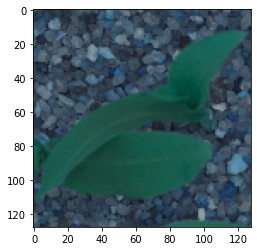

In [ ]:
 img=cv2.resize(cv2.imread(file[0]), (128, 128))
 plt.imshow(img,cmap='Greys_r')

In [ ]:
blurImg = cv2.GaussianBlur(img, (5, 5), 0)
hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)
lower_green = (25, 40, 50)
upper_green = (75, 255, 255)
mask = cv2.inRange(hsvImg, lower_green, upper_green)
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
bMask = mask > 0
clear = np.zeros_like(img, np.uint8)  # Create empty image
clear[bMask] = img[bMask]

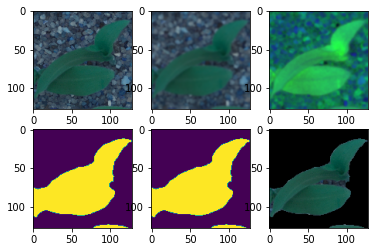

In [ ]:
        plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
        plt.subplot(2, 3, 2); plt.imshow(blurImg)  # Blurred image
        plt.subplot(2, 3, 3); plt.imshow(hsvImg)  # HSV image
        plt.subplot(2, 3, 4); plt.imshow(mask)  # Mask
        plt.subplot(2, 3, 5); plt.imshow(bMask)  # Boolean mask
        plt.subplot(2, 3, 6); plt.imshow(clear)  # Image without background

In [ ]:
clear.shape

(128, 128, 3)

In [ ]:
input=clear.reshape(-1, 128, 128, 3)

In [ ]:
a=np.argmax(final_cnn_model.predict(input), axis=-1)

In [ ]:
le.inverse_transform(a)[0]

'Maize'

### Prediction of Image : Maize

## Observations

1. Preprocessing of images by removing background helped removed lot of noise from the data.

2. The samples were scaled down to 128 * 128, to reduce the number of data points to be processed for the algorithms and to execute within the Google Collab Restrictions. Kaggle seemed to be faster in terms of execution and CPU power, the only issue being the ability to store the models and retrieve them back.

3. Supervised learning using SVC had even after scaling the image at 128 * 128 with 3 channels resulted in  49152 features against the train sample size of ~3800. To reduce the feature size PCA was used to reduce the number of features equal to number of samples. As the images were preprocessed to remove the background, it helpe in terms reducing the features to a smaller set.

SVC resulted in  an accuracy of 70%

4. Fully connected network was trained for 50 epochs. It did not perform any better than SVC and gave a validation accuracy of 74%. The training accuracy was over > 90%. Probabaly we need to look at cases that are failing then check whether it is case of background taking more significance.


5. Luckily, I was able to train the CNN Model and also use the checkpoint to save the best model on another session on google collab. Note that, running on pure luck to finish training is not the best of the ways to finish a project with multiple experimentation expectations.

on the saved Model, I could get an accuracy of 83% on the validation test.

The test image was also predicted correctly by the model.  Due to the session restrictions on google collab I could not further investigate which classes had more issues, but reading on the internet suggests that "black grass" and "loose silky bent" are mostly mis-classified as the characteristics of both seem to be same apart from the fact the one appears more in clusters while the other a single strand.

### A note on the project itself

While the project helped understand the concepts on CNN and FNN and its intepolations, the course material needed for this lacked the following

1. A lecture on image manipulation using OpenCV which is mostly used.
2. Common image manipulation techniques required for background removal, edge detection etc.
3. A clear indication of general pitfalls of using collab, what one needs to be aware of. If knowing the platform pitfalls and how to overcome them had to be found out from internet, then it is leaving a lot on the part of GL for helping us make best use of our time.

# PART TWO
**Supervised learning** algorithms work on a predefined premise where there is an expectation that the data would follow a certain separation construct that can be used for classification. For example, data would follow a sigmoid function, or some threshold can be applied to split the data into to two branches in a tree, or we can apply a kernel in SVM to cleanly separate the points. Additionally using PCA as a technique we can reduce the variance in data. For image classifications using PCA can lead to loss of information, in our case say for Black grass and Scent weed, the points that might be discarded may be the points of interest. If images are are not preprocessed, then supervised learning techniques would fail as there would be too much variance in data for it to ignore.

**FNNs** fare better than SL methods as they do not pre-suppose the underlying equation for separation planes. However a fully connected network tries to use all the information that is given to it thereby tends to overfit the model in the training conditions. Using dropouts (0.45) to provide hints to ignore background colors, but it essentially is does not identify features of importance.

**CNNs** The convolution layers of CNN through the use of various kernels ends up identify many features in the images. CNNs for images are equivalent to feature generation and feature importance tasks that are done on normal datasets for supervised ML algorithms. With their ability to better learn different feature sets automatically from the inputs they end up bieng better and faster at classifying images.

# PART THREE

## Cars Dataset

In [ ]:
!ls '/content/drive/MyDrive/AIML/Projects/CNN/data/carImages'

00001.jpg  00004.jpg  00007.jpg  00010.jpg  00013.jpg
00002.jpg  00005.jpg  00008.jpg  00011.jpg  00014.jpg
00003.jpg  00006.jpg  00009.jpg  00012.jpg  00015.jpg


In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/AIML/Projects/CNN/output/cars.csv')

In [ ]:
df.head(15)

File  color        group  ...    year   view       Bbox
0   0001.jpg  white   sports car  ...  2012.0  front  [1,2,3,4]
1   0002.jpg  black        sedan  ...  2018.0   side  [1,2,3,4]
2   0003.jpg    red       pickup  ...  2001.0   side  [1,2,3,4]
3   0004.jpg    red    hatchback  ...  2003.0   back  [1,2,3,4]
4   0005.jpg  white       pickup  ...  2019.0   side  [1,2,3,4]
5   0006.jpg    red  convertible  ...     NaN   side  [1,2,3,4]
6   0007.jpg   blue         jeep  ...  2012.0  front  [1,2,3,4]
7   0008.jpg    red        sedan  ...  2008.0   back  [1,2,3,4]
8   0009.jpg   grey        sedan  ...  2008.0   side  [1,2,3,4]
9   0010.jpg   grey          SUV  ...  2009.0   side  [1,2,3,4]
10  0011.jpg  white        Sedan  ...  2008.0   back  [1,2,3,4]
11  0012.jpg   grey          SUV  ...  2018.0   side  [1,2,3,4]
12  0013.jpg  white        Sedan  ...  2012.0  front  [1,2,3,4]
13  0014.jpg  white          SUV  ...  2002.0   side  [1,2,3,4]
14  0015.jpg    Red    hatchback  ...  2017.0   side  [1,2,3,4]

[15 rows x 8 columns]

In [ ]:
df['label']=""

In [ ]:
cols=df.columns[:-1]

In [ ]:
for col in cols:
  df['label']=df['label']+"\n"+col+": "+df[col].map(str)

In [ ]:
path='/content/drive/MyDrive/AIML/Projects/CNN/data/carImages/*.jpg'

In [ ]:
files = glob(path)

In [ ]:
carsData = []
imgsize=256

# Obtain images and resizing, obtain labels
for img in tqdm(files):
    carsData.append(
        cv2.resize(cv2.imread(img), (imgsize, imgsize))
    )

carsData = np.asarray(carsData)
#imageLabels = pd.DataFrame(imageLabels)

100%|██████████| 15/15 [00:07<00:00,  2.11it/s]


In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_cars(image_list, nrows, ncols, label_list=None, show_labels=False, figsize=(10,10)):
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(nrows, ncols),
                     axes_pad=2.5,
                     share_all=False,
                     )
    #print(class_dict)
    for i in range(nrows*ncols):
        #print(i)
        ax = grid[i]
        ax.set_title(label_list[i], fontdict={'fontsize':10}, color = "k")
        ax.imshow(image_list[i],cmap='Greys_r')
        ax.axis("off")


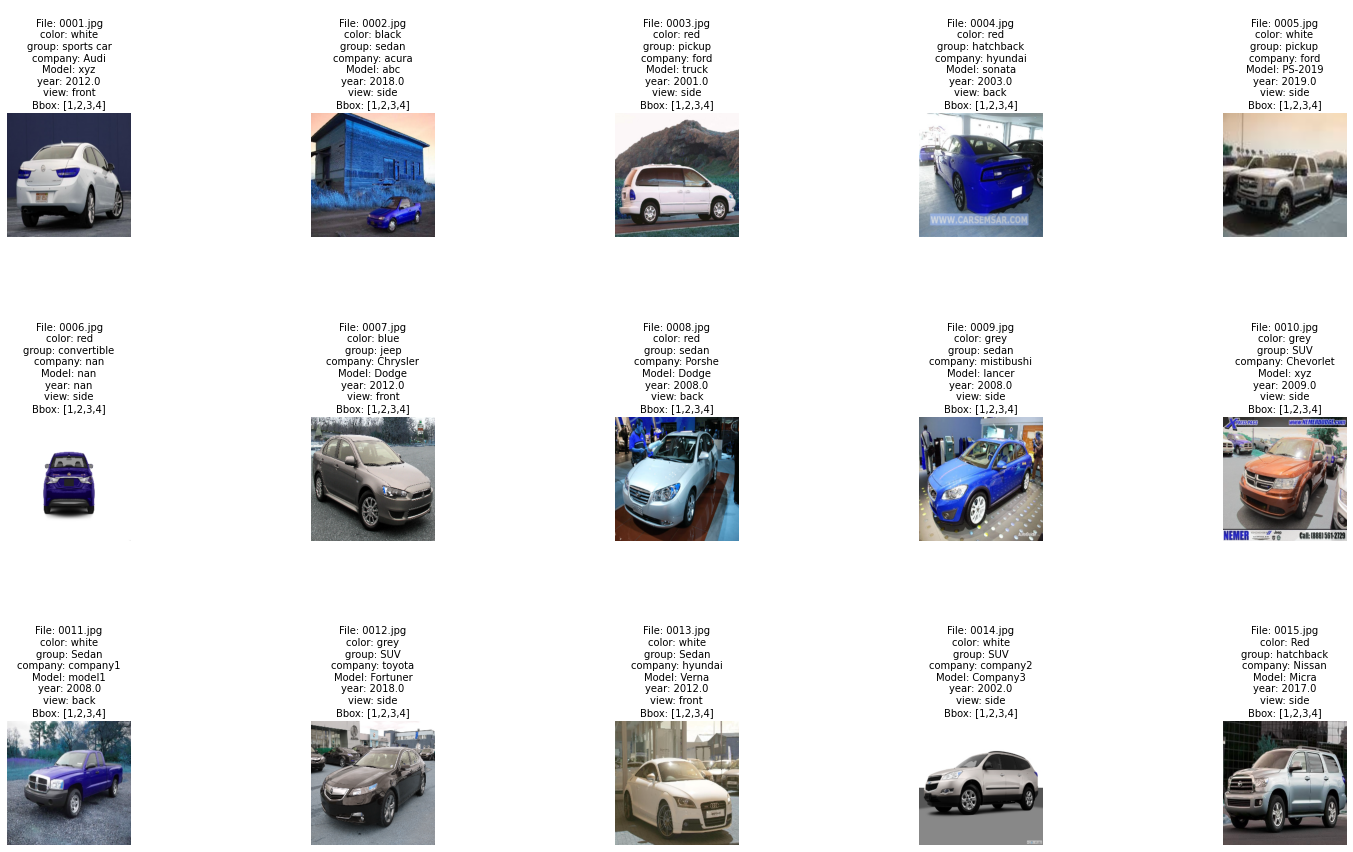

In [ ]:
show_cars(carsData, 3,5 , label_list=df['label'], show_labels=True, figsize=(24,24))

##  Key Challenges

The key challenges with images of 3 dimensional objects is that they can be taken from any angle (360 degrees) from the center of the object. At right angles they will provide very different perspectives of the same object. It is not thereby necessary that the projections in the image captures all possible representations of the object. For example, having the image of the back of the car is not sufficient to be able to predict the car if the production data had the side of the car. Image generation tecniques would not help.

Other challenges include
1. background
2. lighting
3. shades
4. size and quality of images.

Some of the questions that one must consider while creating the dataset are
1. What level of granularity of labels does one want the models to work with?

2. Whether the models should classify based on whole image or build and recognise object within collection of objects?

3. Would you want to identify company of the cars or make of the cars?

4. Would you want to identify the company or the car using some key highlights like the logo, headlights, profile etc?

Basis different requirements we should be collecting as many images as possible to train the classifiers accordingly.

# PART FOUR

## Import and Analyse Dimensions

In [ ]:
pip install tflearn

     |████████████████████████████████| 112kB 7.6MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127300 sha256=d5c1f9646946e264bc016b5ec37c15e804056fcf1c06c2768c360e114451905b
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [ ]:
import tflearn.datasets.oxflower17 as oxflower17

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#X, Y = oxflower17.load_data(one_hot=True, resize_pics=(227, 227))

X, Y = oxflower17.load_data()

100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [ ]:
X.shape

(1360, 224, 224, 3)

In [ ]:
import numpy as np
unique, counts = np.unique(Y, return_counts=True)

In [ ]:
(unique,counts)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80, 80]))

In [ ]:
plt.pie(counts, labels=unique)

plt.axis('equal')
plt.show()

NameError: ignored

Total 1360 samples. Each images is of size 227,227 with 3 channels

The images are tagged to 17 classes , each class has 80 samples.

## Visualise Images

In [ ]:
a=np.unique(Y, return_index=True)
dispdata=[]
dislabels=[]
for i in a[1]:
    dislabels.append(Y[i])
    dispdata.append(X[i])

In [ ]:
show_grid(dispdata, 4, 4, label_list=dislabels, show_labels=True, figsize=(24,24))

NameError: ignored

In [ ]:
a # unique indexes of images of various flowers

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 array([ 14,   1,  16,   5,  15, 101,  35,   0,   4,   6,   7,   2,  13,
         58,  20,  12,   9]))

## Visualisation with different filters

In [ ]:
imgsize=128

### Original Image

In [ ]:
img1 =cv2.resize(X[14],(imgsize,imgsize))
img2= cv2.resize(X[16],(imgsize,imgsize))
img3 =cv2.resize(X[6],(imgsize,imgsize))
img4 =cv2.resize(X[49],(imgsize,imgsize))
img5 =cv2.resize(X[22],(imgsize,imgsize))

NameError: ignored

In [ ]:
f = plt.figure(figsize=(20,20))

f.add_subplot(2, 5, 1,); plt.imshow(img1);
f.add_subplot(2, 5, 2); plt.imshow(img2);
f.add_subplot(2, 5, 3); plt.imshow(img3);
f.add_subplot(2, 5, 4); plt.imshow(img4);
f.add_subplot(2, 5, 5); plt.imshow(img5);

NameError: ignored

### Blur

In [ ]:
blur1=cv2.GaussianBlur(img1,(3,3),0)
blur2=cv2.GaussianBlur(img2,(3,3),0)
blur3=cv2.GaussianBlur(img3,(3,3),0)
blur4=cv2.GaussianBlur(img4,(3,3),0)
blur5=cv2.GaussianBlur(img5,(3,3),0)


NameError: ignored

In [ ]:
f = plt.figure(figsize=(20,20))

f.add_subplot(2, 5, 1,); plt.imshow(blur1);
f.add_subplot(2, 5, 2); plt.imshow(blur2);
f.add_subplot(2, 5, 3); plt.imshow(blur3);
f.add_subplot(2, 5, 4); plt.imshow(blur4);
f.add_subplot(2, 5, 5); plt.imshow(blur5);

NameError: ignored

### Edge Detection

#### Lapalacian

In [ ]:
f = plt.figure(figsize=(20,20))

laplac_1=cv2.Laplacian(blur1, cv2.CV_32F)
laplac_2=cv2.Laplacian(blur2, cv2.CV_32F)
laplac_3=cv2.Laplacian(blur3, cv2.CV_32F)
laplac_4=cv2.Laplacian(blur4, cv2.CV_32F)
laplac_5=cv2.Laplacian(blur5, cv2.CV_32F)

f.add_subplot(2, 5, 1,); plt.imshow(laplac_1);
f.add_subplot(2, 5, 2); plt.imshow(laplac_2);
f.add_subplot(2, 5, 3); plt.imshow(laplac_3);
f.add_subplot(2, 5, 4); plt.imshow(laplac_4);
f.add_subplot(2, 5, 5); plt.imshow(laplac_5);

NameError: ignored

####  Sharpen Edges

In [ ]:
kernel_sharpen_3 = np.array([[-1,-1,-1,-1,-1],
                             [-1,2,2,2,-1],
                             [-1,2,8,2,-1],
                             [-1,2,2,2,-1],
                             [-1,-1,-1,-1,-1]]) / 8.0

In [ ]:
sharp1 = cv2.filter2D(laplac_1, -1, kernel_sharpen_3)
sharp2 = cv2.filter2D(laplac_2, -1, kernel_sharpen_3)
sharp3 = cv2.filter2D(laplac_3, -1, kernel_sharpen_3)
sharp4 = cv2.filter2D(laplac_4, -1, kernel_sharpen_3)
sharp5 = cv2.filter2D(laplac_5, -1, kernel_sharpen_3)

NameError: ignored

In [ ]:
f = plt.figure(figsize=(20,20))

f.add_subplot(2, 5, 1,); plt.imshow(sharp1);
f.add_subplot(2, 5, 2); plt.imshow(sharp2);
f.add_subplot(2, 5, 3); plt.imshow(sharp3);
f.add_subplot(2, 5, 4); plt.imshow(sharp4);
f.add_subplot(2, 5, 5); plt.imshow(sharp5);

The issue with the edge detection mode for the bigger flowers look similar at the edges. an Entire classification scheme was run with only edges and it did not yield in good results.  This notebok thereby does not use edge and only limits iteslf to resize and blur.

## Data Prep

In [ ]:
imgsize=128

In [ ]:
flowerCleaned = []
for img in tqdm(X):
    # Use gaussian blur
    resize_img=cv2.resize(img,(imgsize,imgsize))
    blur_Img = cv2.GaussianBlur(resize_img,(5,5),0)
    #laplac_img=cv2.Laplacian(blur_Img, cv2.CV_32F)
    #sharp_img = cv2.filter2D(laplac_img, -1, kernel_sharpen_3)
    flowerCleaned.append(blur_Img)  # Append adds and object to the end of a list (image without backgroung)

flowerCleaned = np.asarray(flowerCleaned)

100%|██████████| 1360/1360 [00:00<00:00, 3293.74it/s]


In [ ]:
(flowerCleaned.shape, Y.shape)

((1360, 128, 128, 3), (1360,))

In [ ]:
le = LabelEncoder()
le.fit(Y.ravel())
Y_all=le.transform(Y.ravel())

## Models

### Supervised Learning using SVC

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score ,average_precision_score ,accuracy_score,precision_score,recall_score,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
(flowerCleaned.shape, Y.shape)

((1360, 128, 128, 3), (1360,))

#### Prepare Data for SVC

In [ ]:
colsize = len(flowerCleaned[0])*len(flowerCleaned[0][0])*len(flowerCleaned[0][0][0])
X_all=flowerCleaned.reshape(len(flowerCleaned),colsize)
(X_all.shape, Y_all.shape)

((1360, 49152), (1360,))

In [ ]:
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X_all, Y_all, test_size=0.2, random_state=SEED, stratify=Y_all)

(X_train_svm.shape, y_train_svm.shape),(X_test_svm.shape,y_test_svm.shape)

(((1088, 49152), (1088,)), ((272, 49152), (272,)))

##### Perform PCA

In [ ]:
pca = PCA(n_components=min(X_train_svm.shape[1],X_train_svm.shape[0]))
pca.fit(X_train_svm)

PCA(copy=True, iterated_power='auto', n_components=1088, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

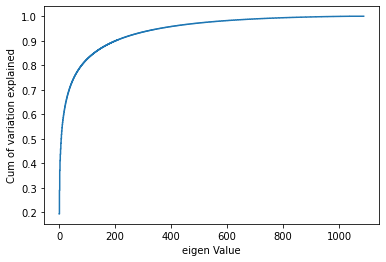

In [ ]:
plt.step(list(range(1,X_train_svm.shape[0]+1)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

In [ ]:
X_train_pca=pca.transform(X_train_svm)
X_test_pca=pca.transform(X_test_svm)

#### Train and Fit SVC

In [ ]:
param_grid = { # SVC
        'kernel': ['rbf', 'poly', 'linear'],
        'C': [0.1, 1, 10,100],
        'class_weight':['balanced',None]
    }
name,best_model,pred,accuracy,precision,recall,f1 = multi_algo_execution(X_train_pca,
               X_test_pca,
               y_train_svm,
               y_test_svm,
               SVC(),
               'SVC',
               param_grid,randomSearch=True)

print('bestModel {0}'.format(best_model))
print('accuracy {0}'.format(accuracy))
print('precision {0}'.format(precision))
print('recall {0}'.format(recall))
print('f1 {0}'.format(f1))

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   37.9s
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  1.2min finished


bestModel SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
accuracy 0.1213235294117647
precision 0.3469945355191257
recall 0.1213235294117647
f1 0.10819657284782036


bestModel SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
accuracy 0.10294117647058823
precision 0.307703081232493
recall 0.10294117647058823
f1 0.07951160305539352

### NN Data Prep

In [ ]:
SEED=1333

X_train_fnn, X_test_fnn, y_train_fnn, y_test_fnn = train_test_split(flowerCleaned, Y_all, test_size=0.2, random_state=SEED, stratify=Y_all)

(X_train_fnn.shape, y_train_fnn.shape),(X_test_fnn.shape,y_test_fnn.shape)

(((1088, 128, 128, 3), (1088,)), ((272, 128, 128, 3), (272,)))

In [ ]:
y_train_cat=to_categorical(y_train_fnn)
y_test_cat=to_categorical(y_test_fnn)

(X_train_fnn.shape,X_test_fnn.shape),(y_train_cat.shape,y_test_cat.shape)

(((1088, 128, 128, 3), (272, 128, 128, 3)), ((1088, 17), (272, 17)))

Samples from the training set

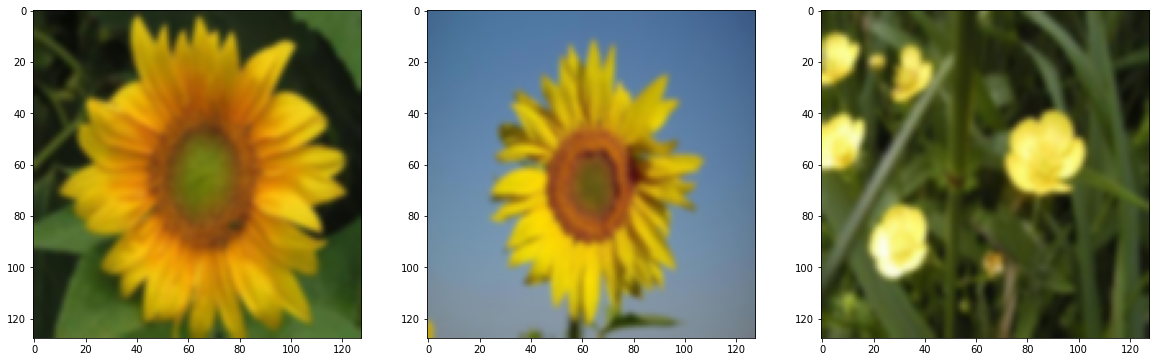

In [ ]:
f = plt.figure(figsize=(20,20))

f.add_subplot(2, 3, 1,); plt.imshow(X_train_fnn[0]);
f.add_subplot(2, 3, 2); plt.imshow(X_train_fnn[1]);
f.add_subplot(2, 3, 3); plt.imshow(X_train_fnn[3]);


Samples from the test set

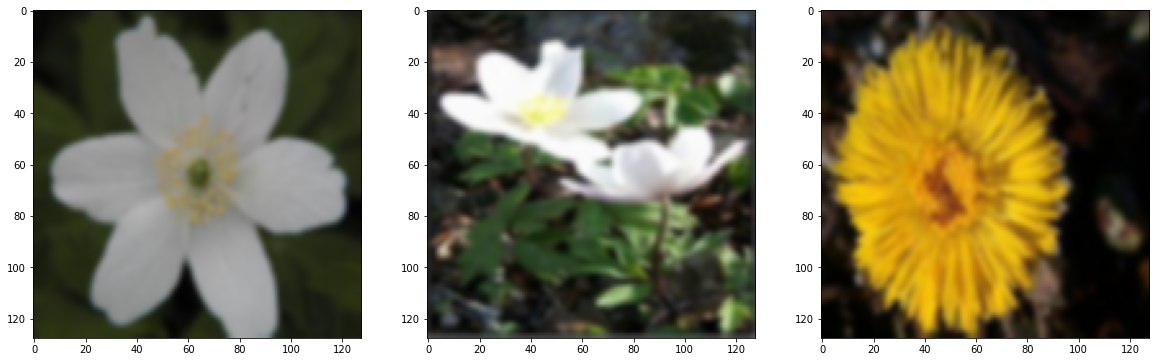

In [ ]:
f = plt.figure(figsize=(20,20))

f.add_subplot(2, 3, 1,); plt.imshow(X_test_fnn[0]);
f.add_subplot(2, 3, 2); plt.imshow(X_test_fnn[1]);
f.add_subplot(2, 3, 3); plt.imshow(X_test_fnn[3]);

### FNN

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
checkpoint_path = '/content/drive/MyDrive/AIML/Projects/CNN/output/fnn_model_flwr'

In [ ]:
BATCH_SIZE=32

In [ ]:
datagen =ImageDataGenerator (rescale=1./255,
            featurewise_center=True,
            featurewise_std_normalization=True,
        )
datagen.fit(X_train_fnn)

In [ ]:
fnn_model=ffn_model(actfn='relu',kernel_initializer='he_normal',batchnorm=1,dropout=0.55,drop=1,hiddennodes=3,nodes=[4000,400,64],target=17)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 49152)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 4000)              196612000 
_________________________________________________________________
batch_normalization_3 (Batch (None, 4000)              16000     
_________________________________________________________________
dropout_3 (Dropout)          (None, 4000)              0         
_________________________________________________________________
activation_4 (Activation)    (None, 4000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 400)               1600400   
_________________________________________________________________
batch_normalization_4 (Batch (None, 400)              

In [ ]:
#tensorflow
run_fnn('FullyConnected_Flower',fnn_model,datagen,
            X_train_fnn,y_train_cat,
            X_test_fnn,y_test_cat,
            X_test_fnn,y_test_cat,
            n_epochs=50,n_batch=BATCH_SIZE)

new function
Epoch 1/50
34/34 [==============================] - 7s 56ms/step - batch: 16.5000 - size: 32.0000 - loss: 3.1000 - acc: 0.1075 - val_loss: 7.4343 - val_acc: 0.1838
Epoch 2/50
34/34 [==============================] - 2s 52ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.6810 - acc: 0.1801 - val_loss: 3.6905 - val_acc: 0.1801
Epoch 3/50
34/34 [==============================] - 2s 52ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.4600 - acc: 0.2279 - val_loss: 2.5708 - val_acc: 0.2500
Epoch 4/50
34/34 [==============================] - 2s 51ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.3493 - acc: 0.2445 - val_loss: 2.2348 - val_acc: 0.2831
Epoch 5/50
34/34 [==============================] - 2s 52ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.2353 - acc: 0.2868 - val_loss: 2.0726 - val_acc: 0.3419
Epoch 6/50
34/34 [==============================] - 2s 51ms/step - batch: 16.5000 - size: 32.0000 - loss: 2.1726 - acc: 0.2978 - val_loss: 1.9990 - val_acc: 0.3824
Epo

KeyboardInterrupt: ignored

Highly overfit model.. Training accuracy is high at 93% while Validationa accuracy is very low

### CNN

In [ ]:
%tensorflow_version 2.x

In [ ]:
CNN_checkpoint_path = '/content/drive/MyDrive/AIML/Projects/CNN/output/cnn_model_flwr'

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [ ]:
def cnn_flower_model():
    model = Sequential()

    model.add(Conv2D(filters=96, kernel_size=(3, 3), strides=(1, 1), input_shape=(128, 128, 3),
                activation='relu'))

    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu'))
    model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu'))

    model.add(MaxPool2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten()) # Flatten the input
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(17, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
X_train_fnn.shape

(1088, 128, 128, 3)

In [ ]:
y_train_cat.shape

(1088, 17)

In [ ]:
X_test_fnn.shape

(272, 128, 128, 3)

In [ ]:
y_test_cat.shape

(272, 17)

In [ ]:
BATCH_SIZE=32
EPOCHS=2
def train_flower_model(model):
    checkpoint = ModelCheckpoint(CNN_checkpoint_path, verbose=1, save_best_only=True)
    # Generates batches of image data with data augmentation
    datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                            width_shift_range=0.2, # Range for random horizontal shifts
                            height_shift_range=0.2, # Range for random vertical shifts
                            zoom_range=0.2, # Range for random zoom
                            horizontal_flip=True, # Randomly flip inputs horizontally
                            vertical_flip=True) # Randomly flip inputs vertically

    datagen.fit(X_train_fnn)
    # Fits the model on batches with real-time data augmentation
    clf_history = model.fit(datagen.flow(X_train_fnn, y_train_cat, batch_size=BATCH_SIZE),
                   steps_per_epoch=X_train_fnn.shape[0] // BATCH_SIZE,
                   epochs=EPOCHS,
                   verbose=2,
                   callbacks=[checkpoint],
                   validation_data=(X_test_fnn, y_test_cat))

In [ ]:
train_flower_model(cnn_flower_model())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 96)      2688      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 96)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 62, 62, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 256)       221440    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 29, 256)       0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 29, 29, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 384)      

After spending 3 saturdays and sundays, I could not get over this error. If you note the same network ran without any issue earlier. Moving forward. We should not be expected to waste time fighiting collab. There is nothing wrong with the code. It is pure play an issue with the environment.

In [ ]:
 fig, ax = plt.subplots(1, 1, figsize=(10,6))
    plt.title(title)
    ax.plot(clf_history.history['loss'], 'r', label='train')
    ax.plot(clf_history.history['val_loss'], 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=8)
    ax.set_ylabel(r'Loss', fontsize=8)
    ax.legend()
    ax.tick_params(labelsize=20)

    # Plot the accuracy
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    ax.plot(clf_history.history['acc'], 'r', label='train')
    ax.plot(clf_history.history['val_acc'], 'b' ,label='val')
    ax.set_xlabel(r'Epoch', fontsize=8)
    ax.set_ylabel(r'Accuracy', fontsize=8)
    ax.legend()
    ax.tick_params(labelsize=20)

### CNN with Transfer Learning

#### VGG19 without

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input


In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, pooling='avg')
print(base_model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [ ]:
(flowerCleaned.shape, Y.shape)

((1360, 128, 128, 3), (1360,))

In [ ]:
y_train_cat=to_categorical(Y_all)

In [ ]:
X_vgg_19 =[]
for img in tqdm(flowerCleaned):
  a=preprocess_input(img)
  X_vgg_19.append(base_model.predict(np.expand_dims(a,axis=0))[0])

100%|██████████| 1360/1360 [00:09<00:00, 145.95it/s]


In [ ]:
X = pd.DataFrame(X_vgg_19)
X.shape

(1360, 512)

In [ ]:
def mymodel(actfn='relu',kernel_initializer=None,batchnorm=0,dropout=0.3,drop=0,hiddennodes=2,nodes=[128,64],input_shp=(128,128,3), target=12):
    model = Sequential()
    model.add(Flatten(input_shape=input_shp))
    for i in range(0,hiddennodes):
        model.add(Dense(nodes[i],kernel_initializer=kernel_initializer))
        if batchnorm:
            model.add(BatchNormalization())
        if drop:
            model.add(Dropout(dropout))
        model.add(Activation(actfn))
    model.add(Dense(target))
    model.add(Activation('softmax'))
    return model

In [ ]:
flowerModel=mymodel(actfn='relu',kernel_initializer='he_normal',
                    batchnorm=1,dropout=0.55,drop=1,hiddennodes=3,
                    nodes=[1024,512,256],input_shp=(512,), target=17)

In [ ]:
flowerModel.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(flowerModel.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_3 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
activation_30 (Activation)   (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)              

In [ ]:
flowerModel.fit(X, y_train_cat, epochs=100, batch_size=100, verbose=True)

Train on 1360 samples
Epoch 1/100
1360/1360 [==============================] - 0s 211us/sample - loss: 3.3659 - acc: 0.0816
Epoch 2/100
1360/1360 [==============================] - 0s 55us/sample - loss: 3.0944 - acc: 0.1066
Epoch 3/100
1360/1360 [==============================] - 0s 55us/sample - loss: 2.9176 - acc: 0.1515
Epoch 4/100
1360/1360 [==============================] - 0s 58us/sample - loss: 2.8175 - acc: 0.1676
Epoch 5/100
1360/1360 [==============================] - 0s 58us/sample - loss: 2.7317 - acc: 0.1816
Epoch 6/100
1360/1360 [==============================] - 0s 59us/sample - loss: 2.7038 - acc: 0.1949
Epoch 7/100
1360/1360 [==============================] - 0s 52us/sample - loss: 2.5505 - acc: 0.2118
Epoch 8/100
1360/1360 [==============================] - 0s 66us/sample - loss: 2.5285 - acc: 0.2213
Epoch 9/100
1360/1360 [==============================] - 0s 61us/sample - loss: 2.4699 - acc: 0.2309
Epoch 10/100
1360/1360 [==============================] - 0s 53us/sa

In [ ]:
to_be_predicted='/content/drive/MyDrive/AIML/Projects/CNN/data/Prediction - Flower.jpg'

In [ ]:
file=glob(to_be_predicted)

In [ ]:
file

['/content/drive/MyDrive/AIML/Projects/CNN/data/Prediction - Flower.jpg']

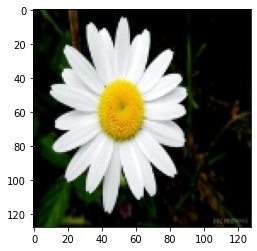

In [ ]:
img=cv2.resize(cv2.imread(file[0]), (128, 128))
im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(im_rgb)

In [ ]:
    resize_img=cv2.resize(im_rgb,(imgsize,imgsize))
    blur_Img = cv2.GaussianBlur(resize_img,(5,5),0)

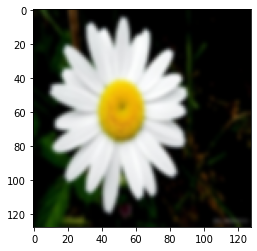

In [ ]:
plt.imshow(blur_Img)

In [ ]:
blur_Img.shape

(128, 128, 3)

In [ ]:
a=preprocess_input(blur_Img)

In [ ]:
flwr=(base_model.predict(np.expand_dims(a,axis=0)))

In [ ]:
flwr.shape

(1, 512)

In [ ]:
b=flowerModel.predict(flwr)
b

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0.]], dtype=float32)

In [ ]:
index=np.argmax(b, axis=-1)

In [ ]:
le.inverse_transform(index)[0]

9

# PART FIVE

Explain in depth your strategy to maintain and support the AIML image classifier after it in production.

General algorithms are trained on very less amount of the possible unvierse of data.  Machines also suffer from the humans can interpret context aware data, while new data as it appears context may be entirely different. We may need to have a human feedback loop on where the classifications are going wrong. The problem is two fold ...
(A) when more data arrives, the nature of data might change in a from that the underlying assumptions and chocies that we have made regarding the algorithms etc. may differ.

(B) The model might have been trained in by teams which are not the ones that support them...

(C) In almost all cases, we would need to ensure that data confirms to the input conditions that were used to create the model.

Additionally, another approach may be to uses a consensus or ensemble of various trained models to reduce the error rate.  Another approach could be acutally to use unsupervised techniques to identify clusters in the data that we have exposure to and subject each cluster to a model which trained on similar clusters. A collection of all of these approaches is what would probably help in maintaining a machine learning algortithm.